# Intra - Inter connectivity : comparing quocients to EDSS/SDMT

Create the first figure, that tries to replicate the correlation between intra and inter connectivity
described in existing papers


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statannotations.Annotator import Annotator
import itertools 

# ignore warnings for easier plotting
import warnings
warnings.filterwarnings("ignore")

from load_data import load_data

In [2]:
sns.set(style='darkgrid', context='talk', palette='Set1', font="serif")

In [14]:
# Hue colors order and names
# auxiliar dict to put correct order in the figure
map_hue_color = {
    "EDSS_group": ["EDSS<=3", "EDSS>3"],
    "SDMT_group": ["SDMT>=40", "SDMT<40"],
    "G_norm": ['G_z<=0', 'G_z>0'], 
    "Corr_norm": ['C_z<=0', 'C_z>0'],
    "disease": ["HC", "MS"],
    "GROUP": ["HC", "CIS", "RRMS", "SPMS", "PPMS"],
    "CENTER": ["CLINIC", "MAINZ", "MILAN", "NAPLES", "OSLO", "LONDON", "AMSTERDAM"],
    "groups" : ["HC", "EDSS<=3", "EDSS>3", "SDMT>=40", "SDMT<40"]
    # "GROUP": ["HC", "RRMS", "SPMS", "PPMS"]
}

# get the progressives together.
mapping_prog = {
    "HC": "HC",
    "CIS": "CIS", 
    "RRMS": "RRMS", 
    "SPMS": "PMS", 
    "PPMS": "PMS"
}

df_merged = load_data()
print(len(df_merged))

df_merged = pd.read_csv("/home/gerard/VHIR/MAGNIMS_DEFINITIVE_RESULTS/df_merged_combat.csv")


# For each center, get the number of patients
print(df_merged.groupby("CENTER").size())

# for each center, get the number of patients dividing by disease
print(df_merged.groupby(["CENTER", "disease"]).size())



Initial length: 730
disease
HC    216
MS    514
dtype: int64
QC N: 5
QC Y: 724
LONDON2: 27
697
CENTER
AMSTERDAM    221
CLINIC        66
LONDON        62
MAINZ         76
MILAN         86
NAPLES       104
OSLO          82
dtype: int64
CENTER     disease
AMSTERDAM  HC          48
           MS         173
CLINIC     HC           8
           MS          58
LONDON     HC          19
           MS          43
MAINZ      HC          26
           MS          50
MILAN      HC          30
           MS          56
NAPLES     HC          53
           MS          51
OSLO       HC          24
           MS          58
dtype: int64


In [15]:
## Compute all quocients

# maybe we need to normalize it beforehand 

df_merged["q_Comm_spl"] = df_merged["Comm_ratio"] / df_merged["SC_spl_full"]
df_merged["q_Comm_eff"] = df_merged["Comm_ratio"] / df_merged["SC_eff_full"]
df_merged["q_CC_spl"] = df_merged["CC_ratio_area"] / df_merged["SC_spl_full"]
df_merged["q_CC_eff"] = df_merged["CC_ratio_area"] / df_merged["SC_eff_full"]

x1 = "q_Comm_spl"
x2 = "q_Comm_eff"
x3 = "q_CC_spl"
x4 = "q_CC_eff"
to_correct_for = 'AGE + C(SEX)'

results = smf.ols(f'{x1} ~ {to_correct_for}', data=df_merged).fit()
df_merged[f"{x1}"] = results.resid + results.params.Intercept
results = smf.ols(f'{x2} ~ {to_correct_for}', data=df_merged).fit()
df_merged[f"{x2}"] = results.resid + results.params.Intercept
results = smf.ols(f'{x3} ~ {to_correct_for}', data=df_merged).fit()
df_merged[f"{x3}"] = results.resid + results.params.Intercept
results = smf.ols(f'{x4} ~ {to_correct_for}', data=df_merged).fit()
df_merged[f"{x4}"] = results.resid + results.params.Intercept

results = smf.ols(f'EDSS ~ {to_correct_for}', data=df_merged).fit()
df_merged[f"EDSS"] = results.resid + results.params.Intercept

results = smf.ols(f'SDMT ~ {to_correct_for}', data=df_merged).fit()
df_merged[f"SDMT"] = results.resid + results.params.Intercept


In [16]:
print(len(df_merged))
x1 = "q_Comm_spl"
x2 = "q_Comm_eff"
x3 = "SC_spl_full"
x4 = "SC_eff_full"

# Select only MS
df_merged_nona = df_merged[df_merged["disease"] == "MS"]
print(len(df_merged_nona))
df_merged_nona = df_merged_nona.dropna(subset=[x1, x2, x3, x4, "EDSS", "SDMT",])
print(len(df_merged_nona))

697
489
478


In [ ]:
to_correct_for = 'AGE + C(SEX)'

results = smf.ols(f'{x1} ~ {to_correct_for}', data=df_merged_nona).fit()
df_merged_nona[f"{x1}"] = results.resid + results.params.Intercept
results = smf.ols(f'{x2} ~ {to_correct_for}', data=df_merged_nona).fit()
df_merged_nona[f"{x2}"] = results.resid + results.params.Intercept
results = smf.ols(f'{x3} ~ {to_correct_for}', data=df_merged_nona).fit()
df_merged_nona[f"{x3}"] = results.resid + results.params.Intercept
results = smf.ols(f'{x4} ~ {to_correct_for}', data=df_merged_nona).fit()
df_merged_nona[f"{x4}"] = results.resid + results.params.Intercept

results = smf.ols(f'EDSS ~ {to_correct_for}', data=df_merged_nona).fit()
df_merged_nona[f"EDSS"] = results.resid + results.params.Intercept

results = smf.ols(f'SDMT ~ {to_correct_for}', data=df_merged_nona).fit()
df_merged_nona[f"SDMT"] = results.resid + results.params.Intercept

In [19]:
def annotate(col1, col2, data, multihue=False, **kwargs):
    if len(data[col1]) >= 2 or len(data[col2]) >= 2:
        r, p = stats.pearsonr(data[col1], data[col2])
        ax = plt.gca()

        # hardcoded, udpate if working with other labels
        x_pos = 0.05
        if multihue:
            label = kwargs["label"]
            dict_of_labels = {"CIS": 0, "RRMS": 1, "PMS": 2, 'MS':0, 'HC':1}
            y_pos = 0.9 - dict_of_labels[kwargs["label"]]*0.05
        else:
            label =  " "
            y_pos = 0.9
        
        ax.text(x_pos, y_pos, f'{label} ' + 'r={:.2f}, p={:.2g}'.format(r, p),
                transform=ax.transAxes)

# x1 = "Comm_ratio"
# x2 = "CC_ratio_area"
# x3 = "SC_spl_full"
# x4 = "SC_eff_full"

x1 = "q_Comm_spl"
x2 = "q_Comm_eff"
x3 = "q_CC_spl"
x4 = "q_CC_eff"

sns.set(style='darkgrid', context='talk', palette='Set1', font="serif")

# First quocient
df_x1_y1 = pd.DataFrame({"y": df_merged_nona[x1].values, "x": df_merged_nona["EDSS"].values})
df_x1_y1[" y"] = x1
df_x1_y1[" x"] = "EDSS"

df_x1_y2 = pd.DataFrame({"y": df_merged_nona[x1].values, "x": df_merged_nona["SDMT"].values})
df_x1_y2[" y"] = x1
df_x1_y2[" x"] = "SDMT"

# Second quocient
df_x2_y1 = pd.DataFrame({"y": df_merged_nona[x2].values, "x": df_merged_nona["EDSS"].values})
df_x2_y1[" y"] = x2
df_x2_y1[" x"] = "EDSS"

df_x2_y2 = pd.DataFrame({"y": df_merged_nona[x2].values, "x": df_merged_nona["SDMT"].values})
df_x2_y2[" y"] = x2
df_x2_y2[" x"] = "SDMT"

# Third quocient
df_x3_y1 = pd.DataFrame({"y": df_merged_nona[x3].values, "x": df_merged_nona["EDSS"].values})
df_x3_y1[" y"] = x3
df_x3_y1[" x"] = "EDSS"

df_x3_y2 = pd.DataFrame({"y": df_merged_nona[x3].values, "x": df_merged_nona["SDMT"].values})
df_x3_y2[" y"] = x3
df_x3_y2[" x"] = "SDMT"

# Fourth quocient
df_x4_y1 = pd.DataFrame({"y": df_merged_nona[x4].values, "x": df_merged_nona["EDSS"].values})
df_x4_y1[" y"] = x4
df_x4_y1[" x"] = "EDSS"

df_x4_y2 = pd.DataFrame({"y": df_merged_nona[x4].values, "x": df_merged_nona["SDMT"].values})
df_x4_y2[" y"] = x4
df_x4_y2[" x"] = "SDMT"

# concatenate the four dataframes
df_intra_inter = pd.concat([df_x1_y1, df_x1_y2, df_x2_y1, df_x2_y2, df_x3_y1, df_x3_y2, df_x4_y1, df_x4_y2])

g = sns.lmplot(data=df_intra_inter, x="x", hue=" x", y="y", row=" x", col=" y", facet_kws={"sharex":False, "sharey":False}, 
               legend=False, legend_out=False, scatter_kws={"alpha":0.8}, palette="mako")
g.map_dataframe(annotate, "x", "y", multihue=False)

## Create the correct titles
# plt.legend(bbox_to_anchor=(1.05, 1.1), loc='upper left', borderaxespad=0)
plt.tight_layout()

# plt.savefig("/home/gerard/Desktop/PROGRESS_NEURO/review/Supplementary/correlation_edss.png", dpi=300)
plt.savefig("/home/gerard/Desktop/PROGRESS_NEURO/review/Supplementary/correlation_q.png", dpi=300)


In [21]:
def annotate(col1, col2, data, multihue=False, **kwargs):
    if len(data[col1]) >= 2 or len(data[col2]) >= 2:
        r, p = stats.pearsonr(data[col1], data[col2])
        ax = plt.gca()

        # hardcoded, udpate if working with other labels
        x_pos = 0.05
        if multihue:
            label = kwargs["label"]
            dict_of_labels = {"CIS": 0, "RRMS": 1, "PMS": 2, 'MS':0, 'HC':1}
            y_pos = 0.9 - dict_of_labels[kwargs["label"]]*0.05
        else:
            label =  " "
            y_pos = 0.9
        
        ax.text(x_pos, y_pos, f'{label} ' + 'r={:.2f}, p={:.2g}'.format(r, p),
                transform=ax.transAxes)

x1 = "Comm_ratio"
x2 = "CC_ratio_area"
x3 = "SC_spl_full"
x4 = "SC_eff_full"

# x1 = "q_Comm_spl"
# x2 = "q_Comm_eff"
# x3 = "q_CC_spl"
# x4 = "q_CC_eff"

to_correct_for = 'AGE + C(SEX)'

# results = smf.ols(f'{x1} ~ {to_correct_for}', data=df_merged).fit()
# df_merged[f"{x1}"] = results.resid + results.params.Intercept
# results = smf.ols(f'{x2} ~ {to_correct_for}', data=df_merged).fit()
# df_merged[f"{x2}"] = results.resid + results.params.Intercept
# results = smf.ols(f'{x3} ~ {to_correct_for}', data=df_merged).fit()
# df_merged[f"{x3}"] = results.resid + results.params.Intercept
# results = smf.ols(f'{x4} ~ {to_correct_for}', data=df_merged).fit()
# df_merged[f"{x4}"] = results.resid + results.params.Intercept

# results = smf.ols(f'GMF ~ {to_correct_for}', data=df_merged).fit()
# df_merged[f"GMF"] = results.resid + results.params.Intercept

# results = smf.ols(f'WMF ~ {to_correct_for}', data=df_merged).fit()
# df_merged[f"WMF"] = results.resid + results.params.Intercept

# results = smf.ols(f'LVF ~ {to_correct_for}', data=df_merged).fit()
# df_merged[f"LVF"] = results.resid + results.params.Intercept

sns.set(style='darkgrid', context='talk', palette='Set1', font="serif")

# First quocient
df_x1_y1 = pd.DataFrame({"y": df_merged_nona[x1].values, "x": df_merged_nona["GMF"].values})
df_x1_y1[" y"] = x1
df_x1_y1[" x"] = "GMF"

df_x1_y2 = pd.DataFrame({"y": df_merged_nona[x1].values, "x": df_merged_nona["WMF"].values})
df_x1_y2[" y"] = x1
df_x1_y2[" x"] = "WMF"

df_x1_y3 = pd.DataFrame({"y": df_merged_nona[x1].values, "x": df_merged_nona["LVF"].values})
df_x1_y3[" y"] = x1
df_x1_y3[" x"] = "LVF"

# Second quocient
df_x2_y1 = pd.DataFrame({"y": df_merged_nona[x2].values, "x": df_merged_nona["GMF"].values})
df_x2_y1[" y"] = x2
df_x2_y1[" x"] = "GMF"

df_x2_y2 = pd.DataFrame({"y": df_merged_nona[x2].values, "x": df_merged_nona["WMF"].values})
df_x2_y2[" y"] = x2
df_x2_y2[" x"] = "WMF"

df_x2_y3 = pd.DataFrame({"y": df_merged_nona[x2].values, "x": df_merged_nona["LVF"].values})
df_x2_y3[" y"] = x2
df_x2_y3[" x"] = "LVF"

# Third quocient
df_x3_y1 = pd.DataFrame({"y": df_merged_nona[x3].values, "x": df_merged_nona["GMF"].values})
df_x3_y1[" y"] = x3
df_x3_y1[" x"] = "GMF"

df_x3_y2 = pd.DataFrame({"y": df_merged_nona[x3].values, "x": df_merged_nona["WMF"].values})
df_x3_y2[" y"] = x3
df_x3_y2[" x"] = "WMF"

df_x3_y3 = pd.DataFrame({"y": df_merged_nona[x3].values, "x": df_merged_nona["LVF"].values})
df_x3_y3[" y"] = x3
df_x3_y3[" x"] = "LVF"

# Fourth quocient
df_x4_y1 = pd.DataFrame({"y": df_merged_nona[x4].values, "x": df_merged_nona["GMF"].values})
df_x4_y1[" y"] = x4
df_x4_y1[" x"] = "GMF"

df_x4_y2 = pd.DataFrame({"y": df_merged_nona[x4].values, "x": df_merged_nona["WMF"].values})
df_x4_y2[" y"] = x4
df_x4_y2[" x"] = "WMF"

df_x4_y3 = pd.DataFrame({"y": df_merged_nona[x4].values, "x": df_merged_nona["LVF"].values})
df_x4_y3[" y"] = x4
df_x4_y3[" x"] = "LVF"

# concatenate the four dataframes
df_intra_inter = pd.concat([df_x1_y1, df_x1_y2, df_x1_y3, df_x2_y1, df_x2_y2, df_x2_y3, df_x3_y1, df_x3_y2, df_x3_y3, df_x4_y1, df_x4_y2, df_x4_y3])

g = sns.lmplot(data=df_intra_inter, x="x", hue=" x", y="y", row=" x", col=" y", facet_kws={"sharex":False, "sharey":False}, 
               legend=False, legend_out=False, scatter_kws={"alpha":0.8}, palette="mako")
g.map_dataframe(annotate, "x", "y", multihue=False)

## Create the correct titles
# plt.legend(bbox_to_anchor=(1.05, 1.1), loc='upper left', borderaxespad=0)
plt.tight_layout()

# plt.savefig("/home/gerard/Desktop/PROGRESS_NEURO/review/Supplementary/Suppl_structural_quotient.png", dpi=300)
plt.savefig("/home/gerard/Desktop/PROGRESS_NEURO/review/Supplementary/Suppl_structural.png", dpi=300)


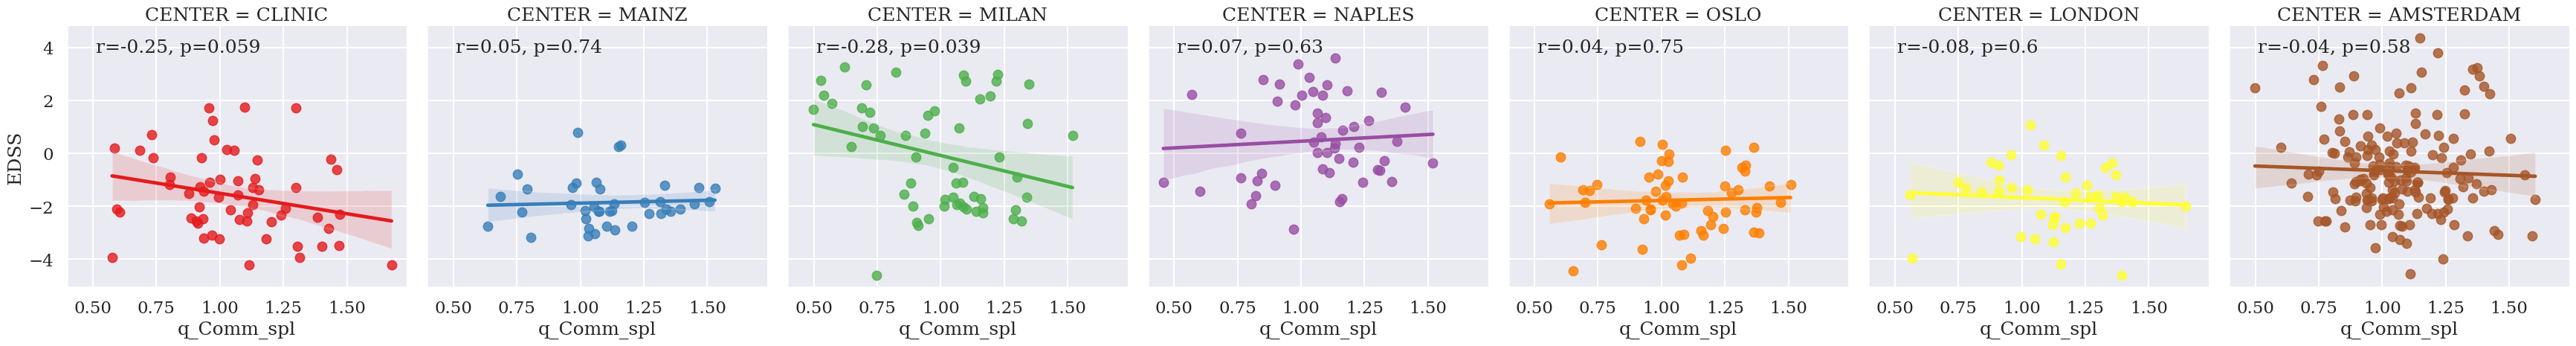

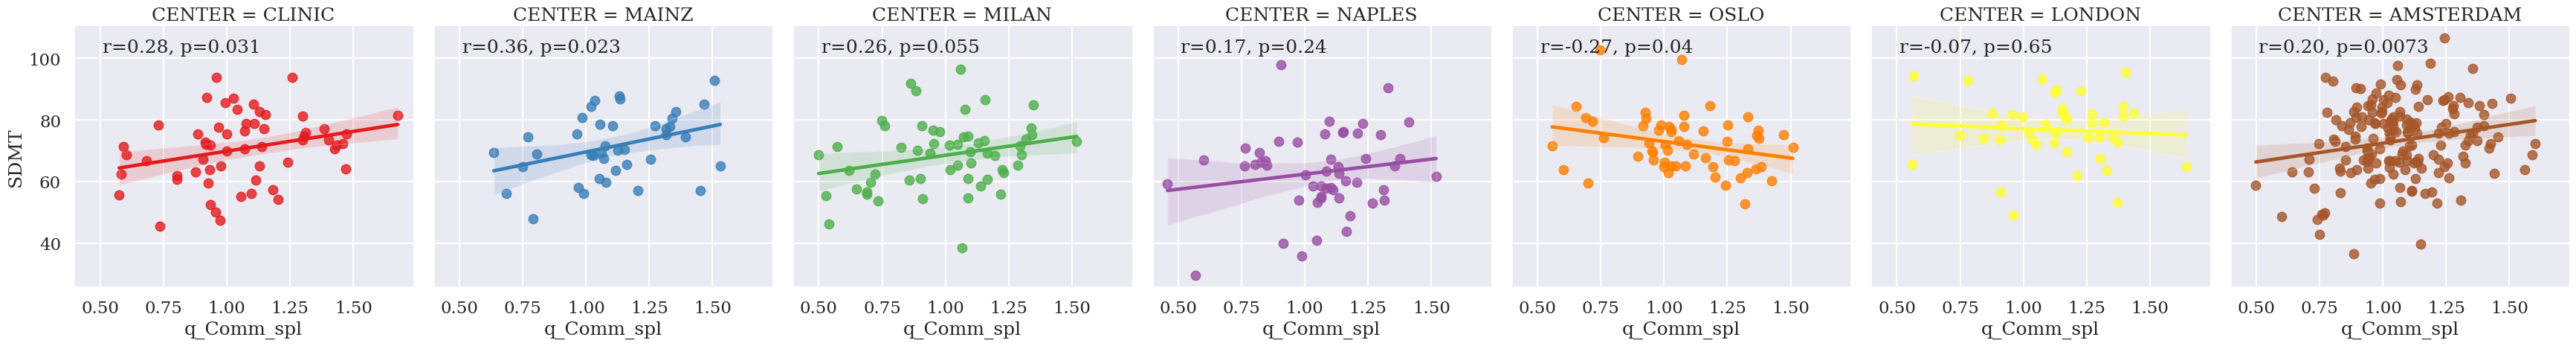

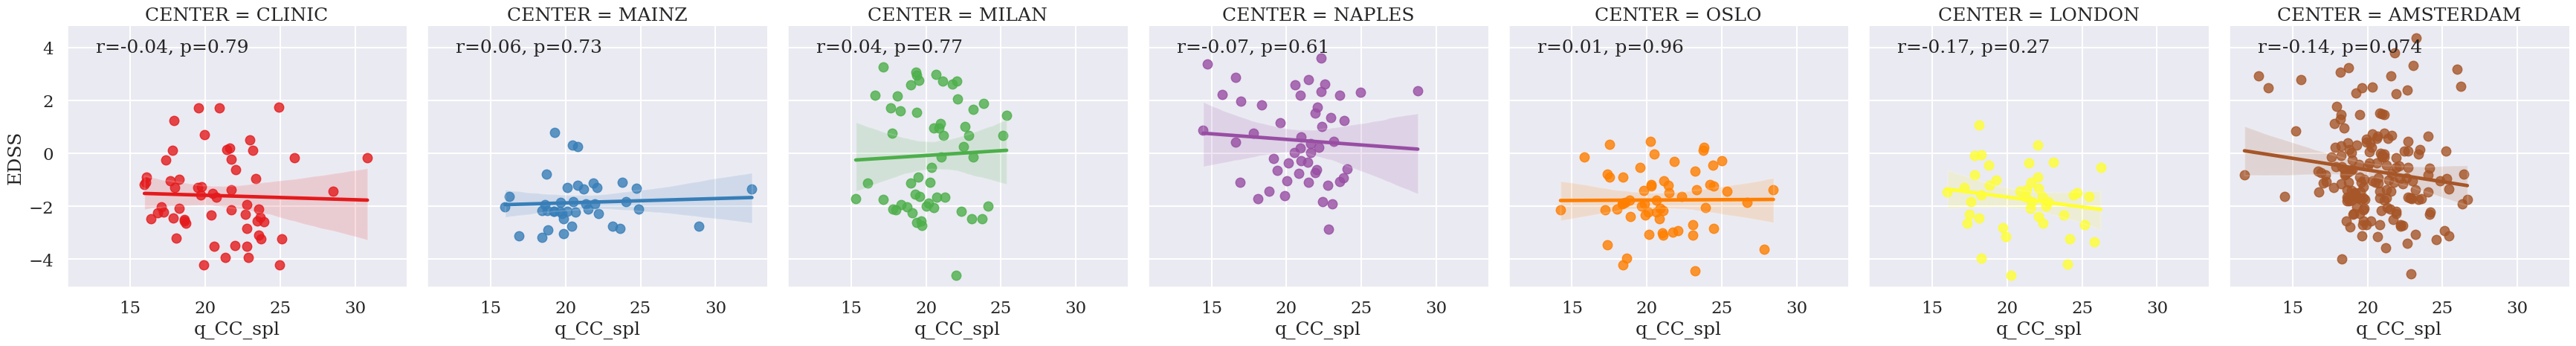

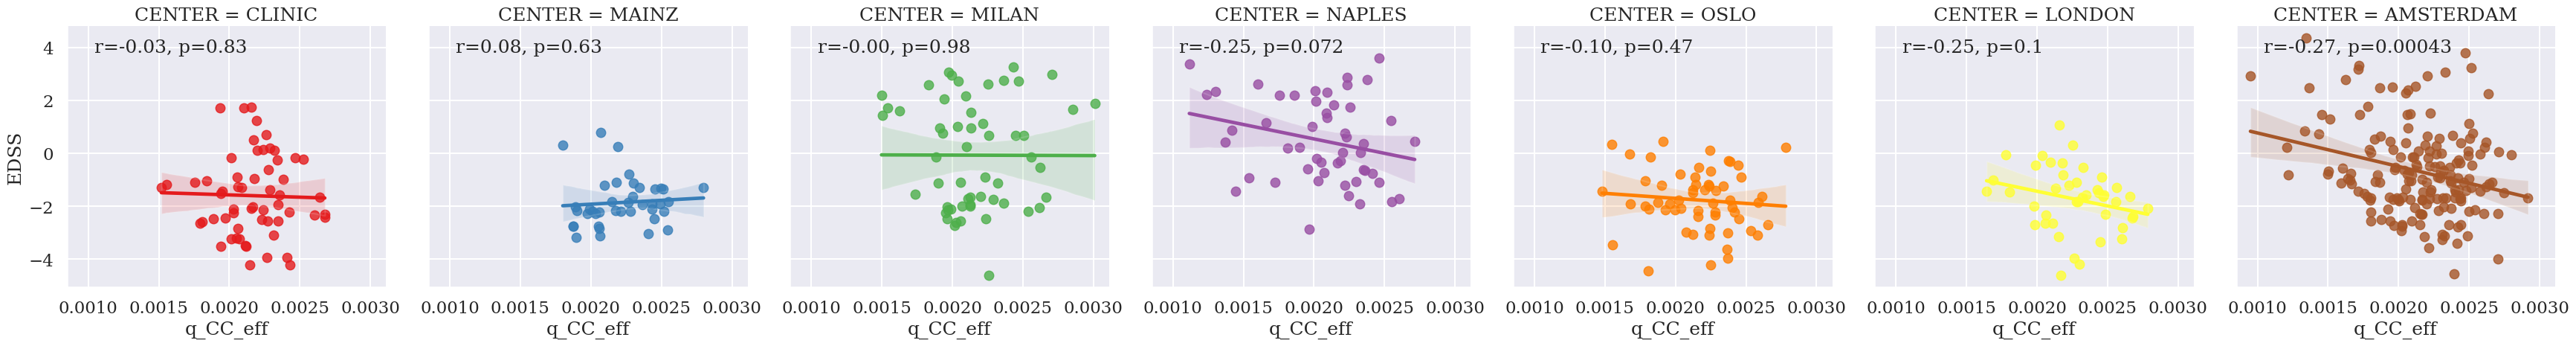

In [8]:
## Do it per center?
q_list = [x1, x2, x3, x4]
var_list = ["EDSS", "SDMT"]

for q in q_list:
    for var in var_list:
        g = sns.lmplot(data=df_merged_nona, x=f"{q}", y=f"{var}", col="CENTER", hue="CENTER")
        g.map_dataframe(annotate, f"{q}", f"{var}", multihue=False)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HC vs. EDSS<=3: t-test independent samples, P_val:1.946e-05 t=4.312e+00
EDSS<=3 vs. EDSS>3: t-test independent samples, P_val:1.558e-01 t=-1.421e+00
SDMT>=40 vs. SDMT<40: t-test independent samples, P_val:5.987e-05 t=4.049e+00
HC vs. EDSS>3: t-test independent samples, P_val:2.013e-03 t=3.102e+00
HC vs. SDMT>=40: t-test independent samples, P_val:4.239e-05 t=4.125e+00
HC vs. SDMT<40: t-test independent samples, P_val:3.607e-11 t=6.865e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HC vs. EDSS<=3: t-test independent samples, P_val:8.023e-06 t=4.512e+00
EDSS<=3 vs. EDSS>3: t-test independent samples, P_val:2.884e-01 t=-1.062e+00
SDMT>=40 vs. SDMT<40: t-test independent sampl

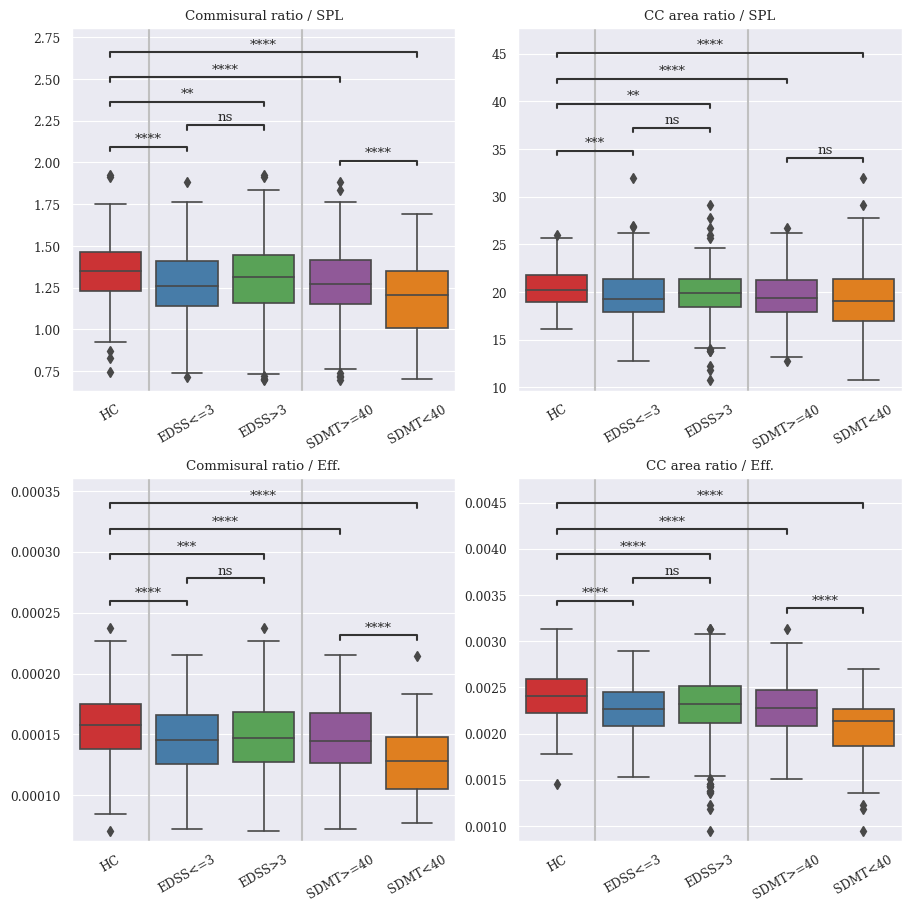

In [17]:
def create_dataframe_categories(df):
    """
    Create the dataframe with the new category and 
    return it
    """

    var_name = "groups"

    df_HC = df[df.GROUP == "HC"]
    df_HC[var_name] = "HC"

    df_lowEDSS = df[df.EDSS_group == "EDSS<=3"]
    df_highEDSS = df[df.EDSS_group == "EDSS>3"]

    df_lowEDSS[var_name] = "EDSS<=3"
    df_highEDSS[var_name] = "EDSS>3"

    # For the SDMT, remember not to include HC 
    df_lowSDMT = df[(df.SDMT_group == "SDMT<40") & (df.GROUP != "HC")]
    df_highSDMT = df[(df.SDMT_group == "SDMT>=40") & (df.GROUP != "HC")]

    df_lowSDMT[var_name] = "SDMT<40"
    df_highSDMT[var_name] = "SDMT>=40"

    # Concatenate all of the dfs
    df_out = pd.concat([df_HC, df_lowEDSS, df_highEDSS, df_lowSDMT, df_highSDMT])
    return df_out

x1 = "q_Comm_spl"
x2 = "q_Comm_eff"
x3 = "q_CC_spl"
x4 = "q_CC_eff"

sns.set(style='darkgrid', context='paper', palette='Set1', font="serif")


df_merged = create_dataframe_categories(df_merged)

## Boxplot differences across groups
# paper
f, axes = plt.subplots(2, 2, figsize=(9,9), constrained_layout=True)

## left G, right cs
statest = "t-test_ind" # Mann-Whitney t-test_ind
axes = axes.T.ravel()
group_pairs = [("HC", "EDSS<=3"), ("HC", "EDSS>3"), ("HC", "SDMT<40"), ("HC", "SDMT>=40"), ("EDSS<=3", "EDSS>3"), ("SDMT<40", "SDMT>=40")]

# set vertical lines dividing categories
for ax in axes:
    ax.axvline(0.5, c="#C0C0C0", lw=1.5)
    ax.axvline(2.5, c="#C0C0C0", lw=1.5)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

# q_Comm_spl
#group_pairs = [("HC", "EDSS>3"), ("HC", "SDMT<40"), ("SDMT<40", "SDMT>=40")]
sns.boxplot(data=df_merged, x="groups", y=x1, order=map_hue_color["groups"], orient="v", ax=axes[0])
annotator = Annotator(axes[0], group_pairs, orient='v', data=df_merged, x="groups", y=x1, order=map_hue_color["groups"], verbose=1)
annotator.configure(test=statest, text_format='star', loc='inside')
annotator.apply_and_annotate()
axes[0].legend([],[], frameon=False)
axes[0].set_title("Commisural ratio / SPL")
axes[0].set(xlabel=None)
axes[0].set(ylabel=None)

# q_Comm_eff
sns.boxplot(data=df_merged, x="groups", y=x2, order=map_hue_color["groups"], orient="v", ax=axes[1])
annotator = Annotator(axes[1], group_pairs, orient='v', data=df_merged, x="groups", y=x2, order=map_hue_color["groups"], verbose=1)
annotator.configure(test=statest, text_format='star', loc='inside')
annotator.apply_and_annotate()
axes[1].legend([],[], frameon=False)
axes[1].set_title("Commisural ratio / Eff.")
axes[1].set(xlabel=None)
axes[1].set(ylabel=None)

# q_CC_spl
sns.boxplot(data=df_merged, x="groups", y=x3, order=map_hue_color["groups"], orient="v", ax=axes[2])
annotator = Annotator(axes[2], group_pairs, orient='v', data=df_merged, x="groups", y=x3, order=map_hue_color["groups"], verbose=1)
annotator.configure(test=statest, text_format='star', loc='inside')
annotator.apply_and_annotate()
axes[2].legend([],[], frameon=False)
axes[2].set_title("CC area ratio / SPL")
axes[2].set(xlabel=None)
axes[2].set(ylabel=None)

# q_CC_eff
sns.boxplot(data=df_merged, x="groups", y=x4, order=map_hue_color["groups"], orient="v", ax=axes[3])
annotator = Annotator(axes[3], group_pairs, orient='v', data=df_merged, x="groups", y=x4, order=map_hue_color["groups"], verbose=1)
annotator.configure(test=statest, text_format='star', loc='inside')
annotator.apply_and_annotate()
axes[3].legend([],[], frameon=False)
axes[3].set_title("CC area ratio / Eff.")
axes[3].set(xlabel=None)
axes[3].set(ylabel=None)

#plt.tight_layout()
plt.savefig("/home/gerard/Desktop/PROGRESS_NEURO/review/Fig4_boxplot_q_final.png", dpi=300)



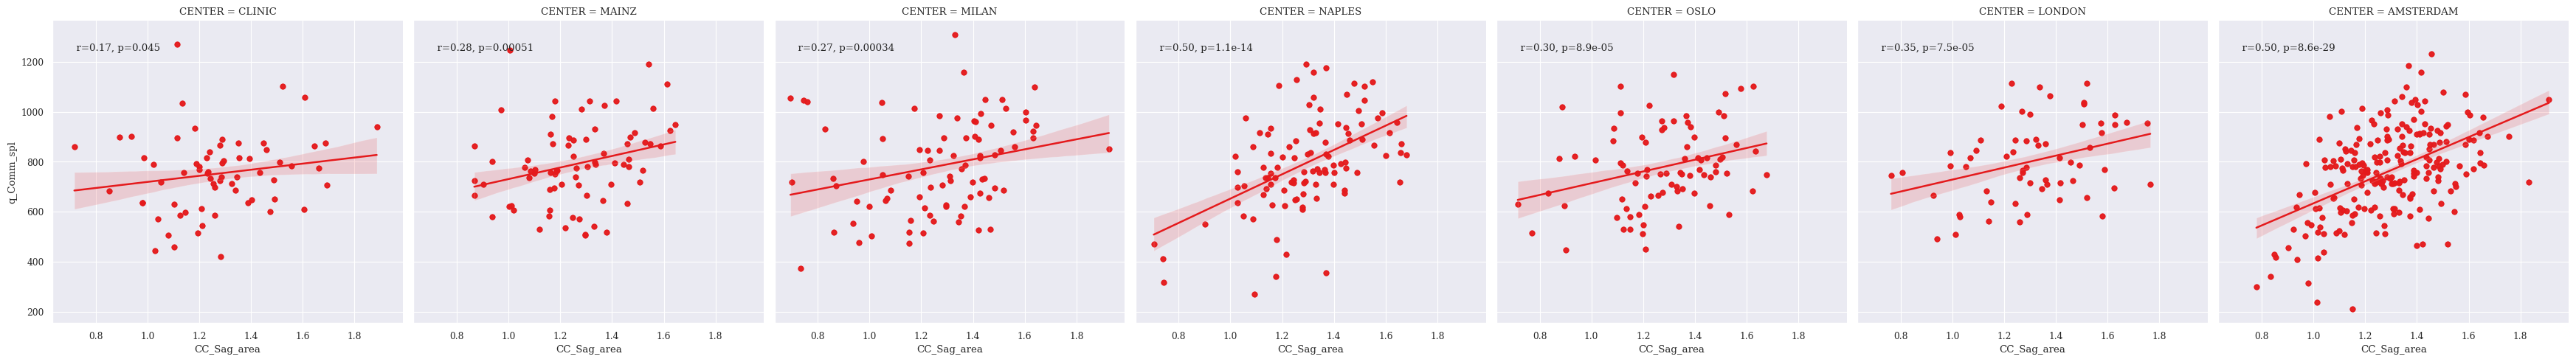

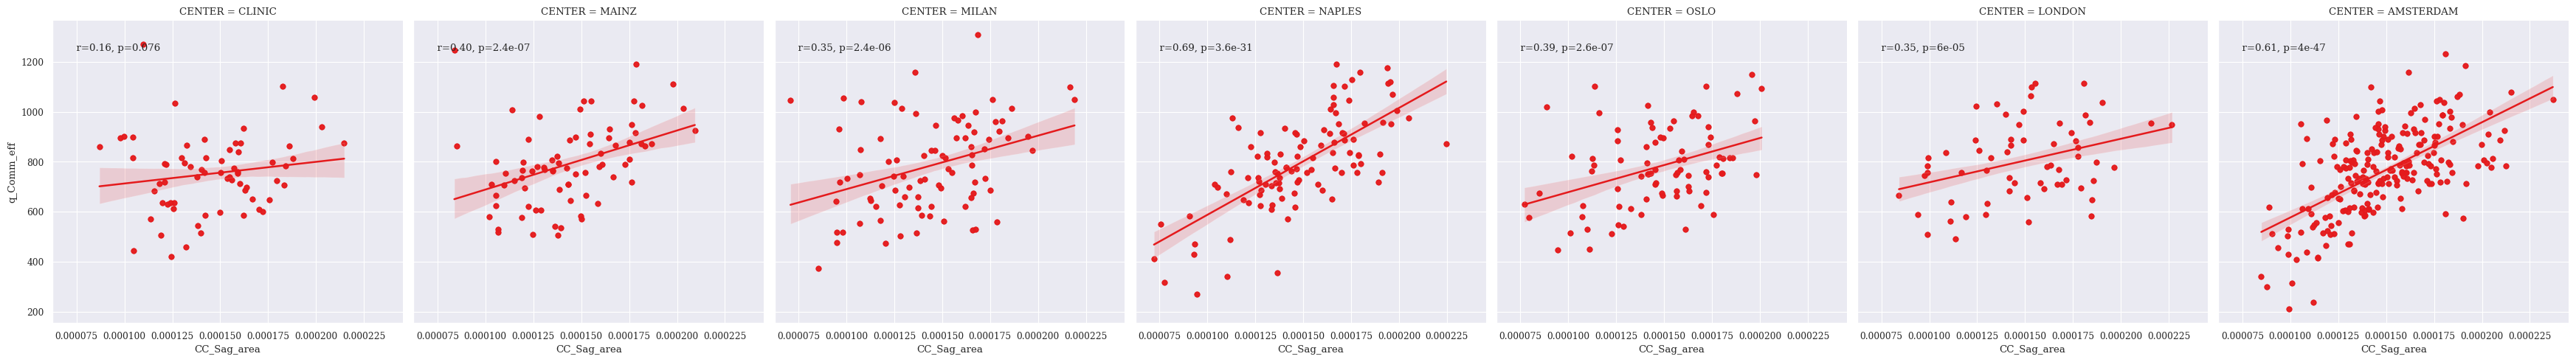

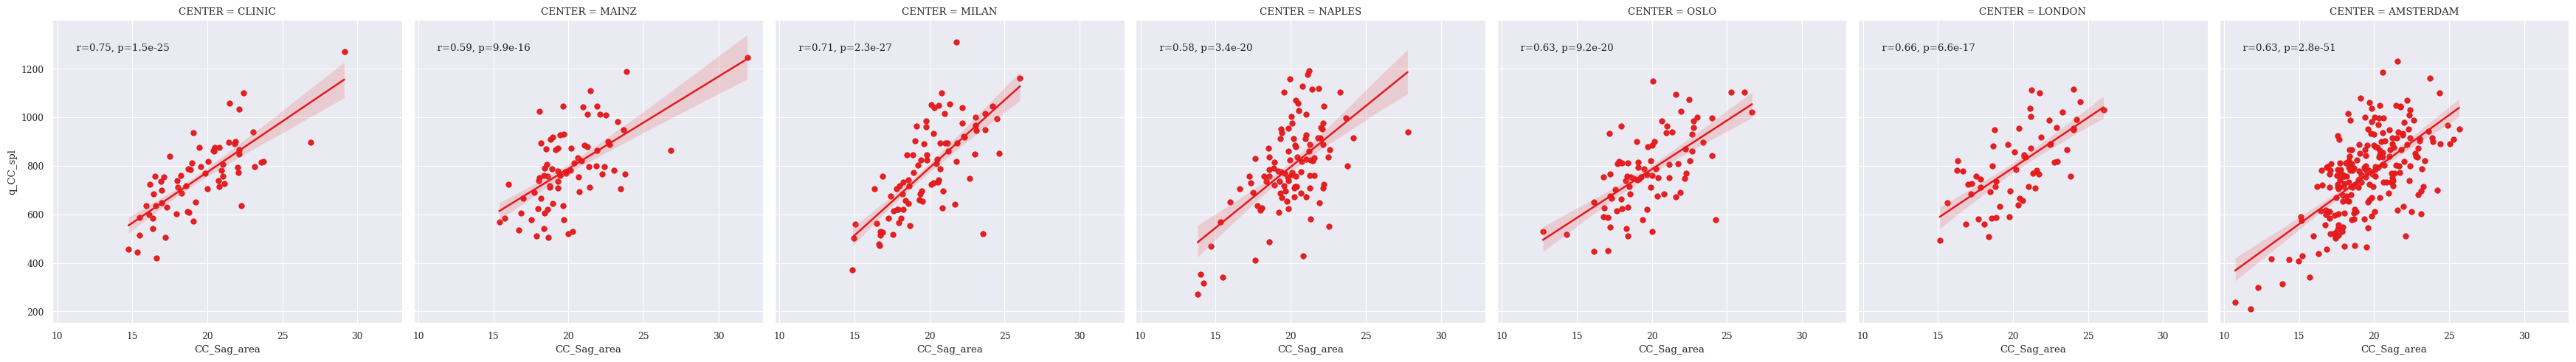

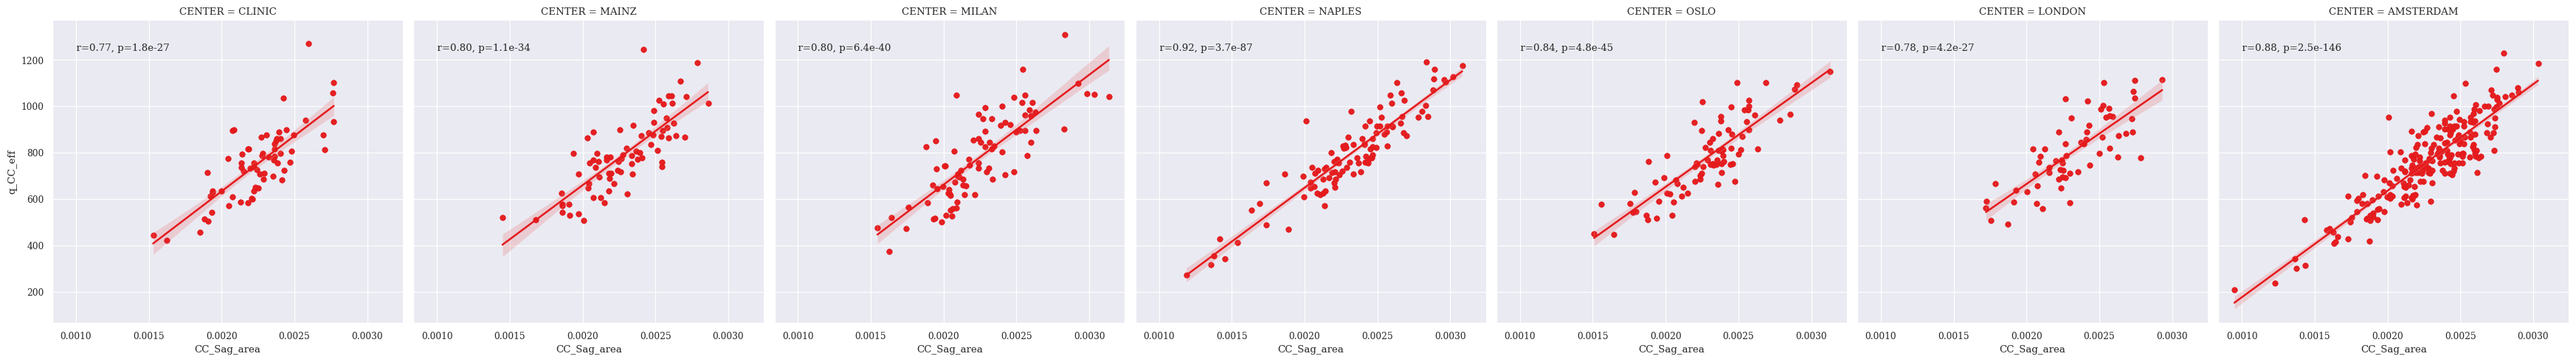

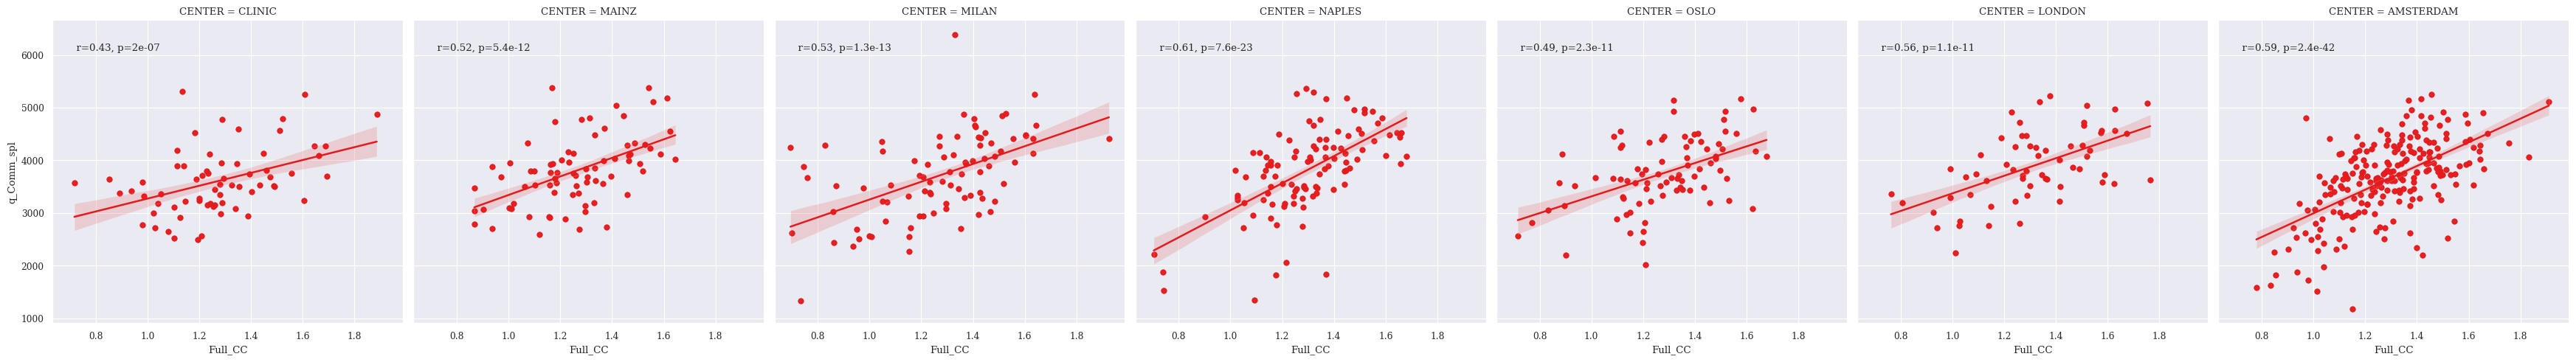

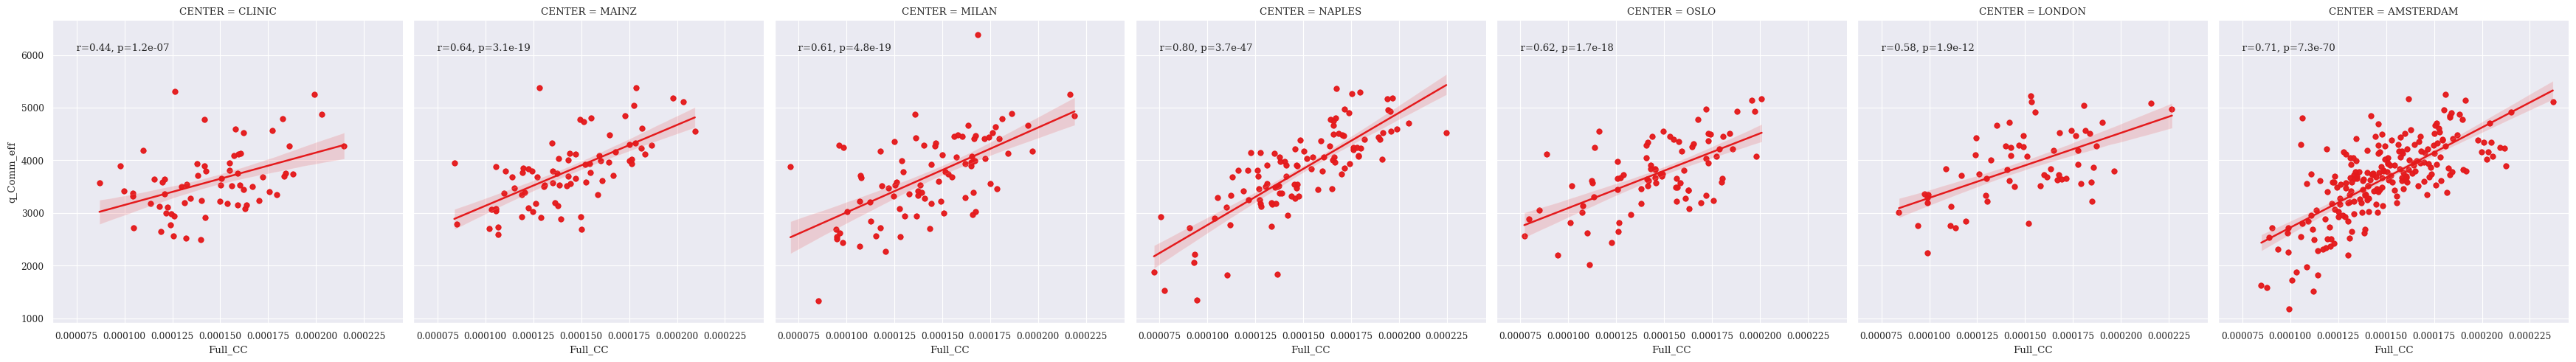

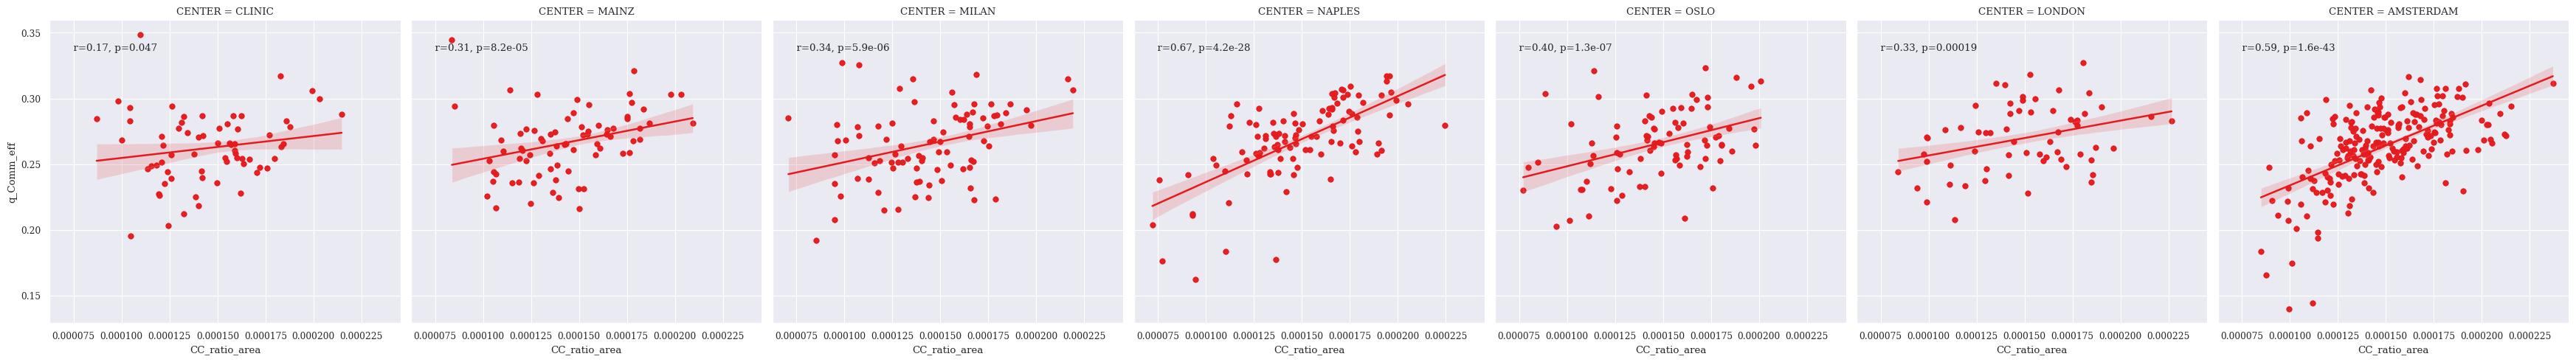

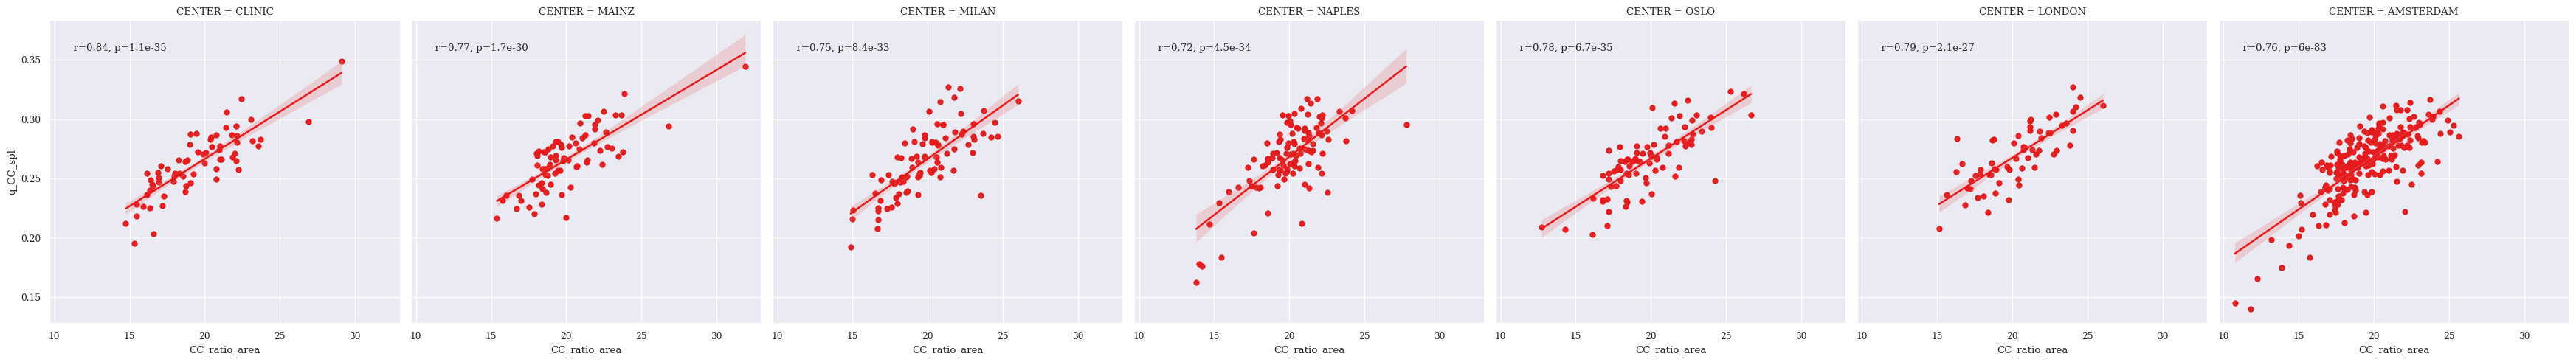

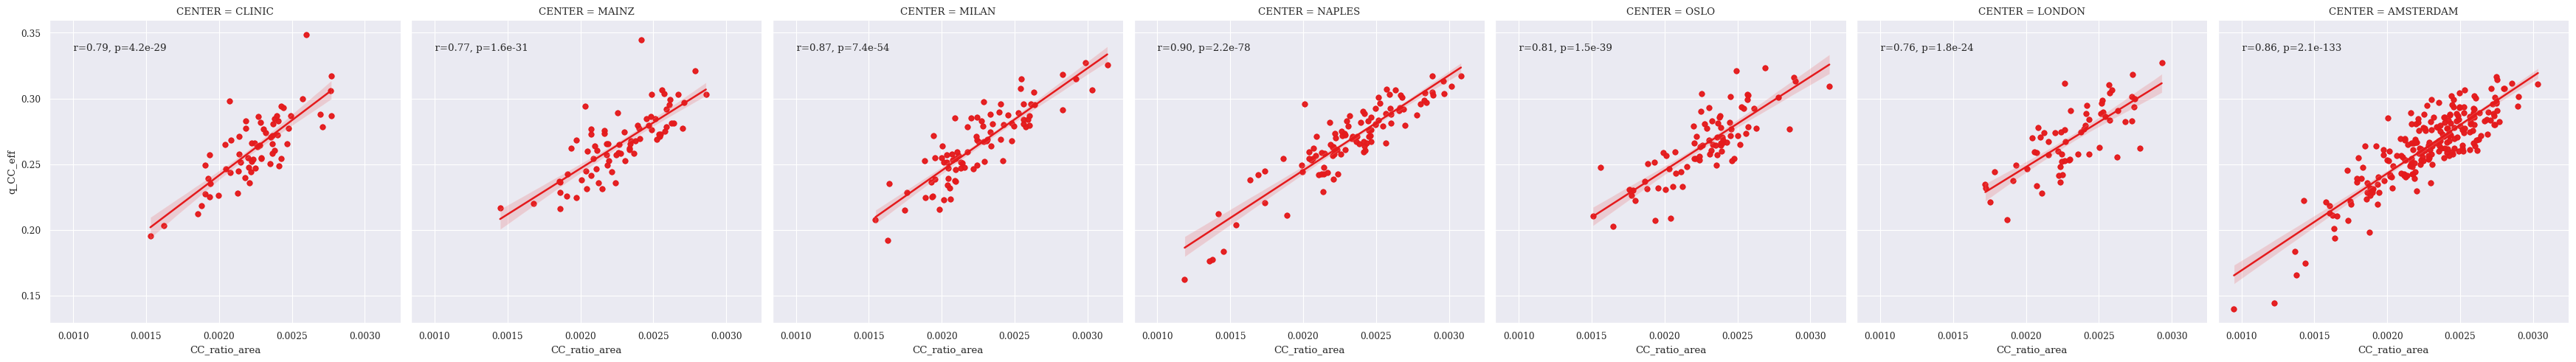

In [10]:
## Comparison with FC

# FC_values = ['FC_spl_full', 'FC_eff_full', 'FC_entropy_full', 'FC_integration_full', 'FC_Corr_total']
FC_values = ['CC_Sag_area', 'Full_CC', 'CC_ratio_area']
# FC_values = ['SC_spl_full', 'SC_eff_full']

Q_list = [x1, x2, x3, x4]

for fc in FC_values:
    for qq in Q_list:
        df_plot = df_merged.dropna(subset=[fc, qq])
        g = sns.lmplot(data=df_merged, x=qq, y=fc, col="CENTER", fit_reg=True, scatter_kws={"alpha":0.8}, legend=True, legend_out=True, palette="viridis")
        g.map_dataframe(annotate, fc, qq, multihue=False)

